## Task 3: Correlation between News Sentiment and Stock Movements

# Goal: Quantify the relationship between news sentiment and daily stock returns.


In [43]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt


# loading 2 datasets(news and stock data)

In [32]:
stock_df = pd.read_csv("prepared_data/task2prepared_stock_data.csv")
print(stock_df.columns)

Index(['Unnamed: 0', 'Date', 'Close', 'High', 'Low', 'Open', 'Volume',
       'source_file'],
      dtype='object')


In [39]:
# Load the stock data that you prepared in Task 2
stock_df = pd.read_csv("prepared_data/task2prepared_stock_data.csv")  # CSV with Open, High, Low, Close, Volume, indicators
stock_df['date'] = pd.to_datetime(stock_df['Date'])  # ensure proper datetime
stock_df = stock_df.sort_values('Date')
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
stock_df.set_index('date', inplace=True)
stock_df['daily_return'] = stock_df['Close'].pct_change()  # compute daily returns
stock_df.head()

,Unnamed: 0,Date,Close,High,Low,Open,Volume,source_file,daily_return
date,,,,,,,,,
2009-01-02,0,2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,../data\NVDA.csv,NaN
2009-01-05,1,2009-01-05,0.203319,0.207904,0.195984,0.197360,705736000,../data\NVDA.csv,0.018370
2009-01-06,2,2009-01-06,0.210196,0.216156,0.204695,0.209279,657904000,../data\NVDA.csv,0.033822
2009-01-07,3,2009-01-07,0.197589,0.205382,0.190483,0.205382,870096000,../data\NVDA.csv,-0.059978
2009-01-08,4,2009-01-08,0.192546,0.195067,0.180626,0.195067,1014496000,../data\NVDA.csv,-0.025522


In [ ]:
# Load the news data 
# 1️⃣ Load CSV safely
news_df = pd.read_csv("../raw_analyst_ratings.csv")
news_df = news_df.sample(10000, random_state=42)
# 2️⃣ Drop unnecessary index column if exists
if 'Unnamed: 0' in news_df.columns:
    news_df.drop(columns=['Unnamed: 0'], inplace=True)

# 3️⃣ Normalize and parse 'date' column
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')  # invalid -> NaT

# 4️⃣ Optional: check rows with missing dates
missing_dates = news_df[news_df['date'].isna()]
print(f"Rows with missing dates: {len(missing_dates)}")

# 5️⃣ Define safe sentiment function
def get_sentiment(text):
    if pd.isna(text) or str(text).strip() == "":
        return [0.0, 0.0]
    blob = TextBlob(str(text))
    return [blob.polarity, blob.subjectivity]

# 6️⃣ Apply sentiment analysis safely
news_df[['polarity', 'subjectivity']] = pd.DataFrame(
    news_df['headline'].apply(get_sentiment).to_list(),
    index=news_df.index
)

# 7️⃣ Optional: filter only rows with valid dates
news_df = news_df.dropna(subset=['date'])

# 8️⃣ Preview
print(news_df.head())

Rows with missing dates: 422
                                                  headline  \
1201723  Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...   
1282616  Mid-Day Market Update: K2M Group Rises On Acqu...   
554075   Aramchol's Failed Past Isn't Its Future; Galme...   
1190332     60 Stocks Moving In Thursday's Mid-Day Session   
192958   Anheuser-Busch shares are trading lower after ...   

                                                       url  \
1201723  https://www.benzinga.com/news/earnings/13/04/3...   
1282616  https://www.benzinga.com/news/18/08/12285391/m...   
554075   https://www.benzinga.com/analyst-ratings/analy...   
1190332  https://www.benzinga.com/news/20/04/15730001/6...   
192958   https://www.benzinga.com/markets/wiim/19/07/14...   

                         publisher       date stock  polarity  subjectivity  
1201723  bret.kenwell@benzinga.com 2013-04-18  SYNT      0.00      0.000000  
1282616                 Lisa Levin 2018-08-30  UEPS      0.00      0.

In [36]:
# Quick summary of the news dataset
print(news_df.info())
print(news_df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 9578 entries, 1201723 to 610523
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   headline      9578 non-null   object        
 1   url           9578 non-null   object        
 2   publisher     9578 non-null   object        
 3   date          9578 non-null   datetime64[ns]
 4   stock         9578 non-null   object        
 5   polarity      9578 non-null   float64       
 6   subjectivity  9578 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 598.6+ KB
None
                                date     polarity  subjectivity
count                           9578  9578.000000   9578.000000
mean   2015-07-26 06:58:06.489872384     0.050343      0.169285
min              2009-08-07 00:00:00    -1.000000      0.000000
25%              2013-01-07 06:00:00     0.000000      0.000000
50%              2015-08-13 00:00:00     0.

#Align News & Stock by Date

In [40]:
# Keep only date part for alignment
news_df['date_only'] = news_df['date'].dt.date
stock_df['date_only'] = stock_df['Date'].dt.date

# Aggregate sentiment per day (average polarity & subjectivity)
daily_sentiment = news_df.groupby('date_only')[['polarity', 'subjectivity']].mean().reset_index()

# Merge with stock returns
merged_df = pd.merge(stock_df, daily_sentiment, on='date_only', how='inner')

# Drop rows without returns
merged_df = merged_df.dropna(subset=['daily_return'])
merged_df.head()


,Unnamed: 0,Date,Close,High,Low,Open,Volume,source_file,daily_return,date_only,polarity,subjectivity
0,150,2009-08-07,0.314262,0.326182,0.309907,0.317013,1401872000,../data\NVDA.csv,0.044969,2009-08-07,0.068182,0.227273
1,151,2009-08-10,0.303947,0.321139,0.302114,0.316555,693312000,../data\NVDA.csv,-0.032823,2009-08-10,0.071296,0.205556
2,153,2009-08-12,0.307844,0.311053,0.296842,0.297071,634940000,../data\NVDA.csv,0.037066,2009-08-12,0.028030,0.137879
3,154,2009-08-13,0.317013,0.318159,0.304635,0.310137,564028000,../data\NVDA.csv,0.029784,2009-08-13,-0.028788,0.262374
4,161,2009-08-24,0.310366,0.320910,0.308532,0.317472,461456000,../data\NVDA.csv,-0.027998,2009-08-24,0.000000,0.000000


In [41]:
cor_polarity = merged_df['polarity'].corr(merged_df['daily_return'])
cor_subjectivity = merged_df['subjectivity'].corr(merged_df['daily_return'])

print(f"Correlation (Polarity vs Returns): {cor_polarity:.4f}")
print(f"Correlation (Subjectivity vs Returns): {cor_subjectivity:.4f}")


Correlation (Polarity vs Returns): -0.0111
Correlation (Subjectivity vs Returns): -0.0192


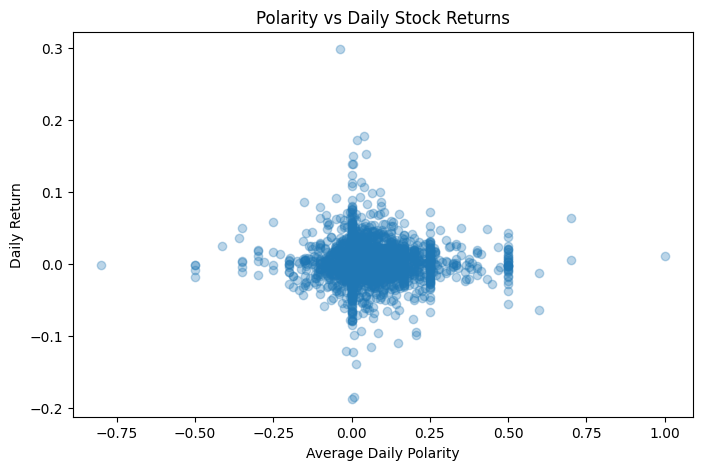

In [44]:
plt.figure(figsize=(8,5))
plt.scatter(merged_df['polarity'], merged_df['daily_return'], alpha=0.3)
plt.title("Polarity vs Daily Stock Returns")
plt.xlabel("Average Daily Polarity")
plt.ylabel("Daily Return")
plt.show()
